In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [2]:
date = '20220802'
dataNo = 2
scanNo = 3

In [3]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [4]:
param_name ='T0050: LS hold time (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[5]
sample3 = unique_param[9]
unit = '(us)'
flcount = scan_data['Total count @ ROI1 (arb. u.)']

In [5]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat.tiff'))
    update_files = list(Path(path_img).glob('seq*_update.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '18000.0(us)')

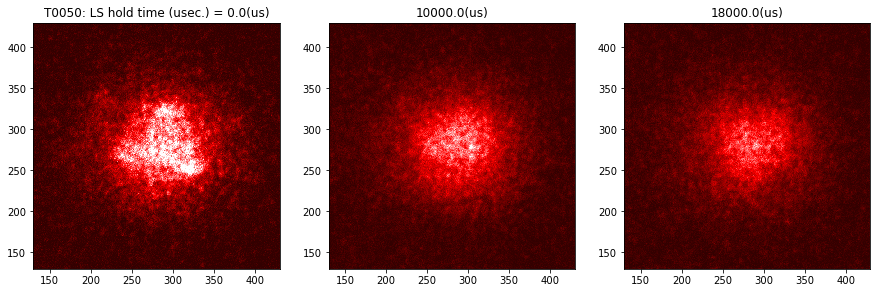

In [7]:
vmin = 0
vmax = 700
xlim_1 = 130
xlim_2 = 430
ylim_1 = 130
ylim_2 = 430

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.01f"%(sample3)+unit)

In [8]:
img_ave_by_unique_param = []
for i in range(len(unique_param)):
    img_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            img_temp.append(img_trans_list[j])
    img_ave_by_unique_param.append(np.average(img_temp, axis=0))

In [9]:
change = True
while change:
    change = False
    for i in range(len(unique_param)-1):
        if unique_param[i]>unique_param[i+1]:
            unique_param[i], unique_param[i+1] = unique_param[i+1], unique_param[i]
            img_ave_by_unique_param[i], img_ave_by_unique_param[i+1] = img_ave_by_unique_param[i+1], img_ave_by_unique_param[i]
            change = True

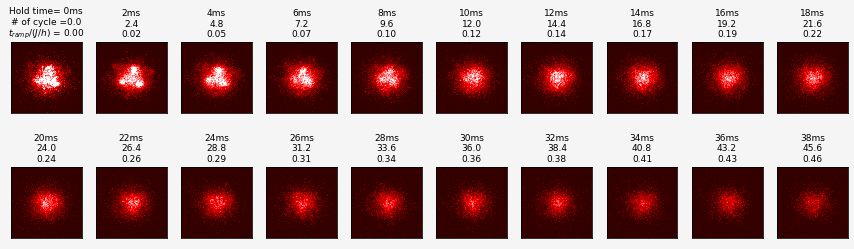

In [60]:
vmin = 50
vmax = 600

column_number = 10
row_number = 2


LSfreq = 1200 #[Hz]
tunneling = 12 #[Hz]
NoOfCycle = unique_param*LSfreq*1e-6
t_over_tunneling = unique_param*1e-6*tunneling

fig, axes = plt.subplots(row_number, column_number, figsize=(15,4), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title('Hold time'+ "= %d"%(unique_param[column_number*i+j]*1e-3)+'ms'+'\n'+'# of cycle =%.01f'%(NoOfCycle[column_number*i+j])+'\n'+r'$t_{ramp}/(J/h)$ = %.02f'%(t_over_tunneling[column_number*i+j]), fontsize=9)
            else:
                axes[i,j].set_title("%d"%(unique_param[column_number*i+j]*1e-3)+'ms'+'\n'+'%.01f'%(NoOfCycle[column_number*i+j])+'\n'+'%.02f'%(t_over_tunneling[column_number*i+j]), fontsize=9)

In [57]:
unique_param_index = 1

def createUniqueTransFiles(img_trans_list, scan_param, unique_param, unique_param_index):
    unique_trans_files = []
    for i in range(len(img_trans_list)):
        if scan_param[i] == unique_param[unique_param_index]:
            unique_trans_files.append(img_trans_list[i])
    return unique_trans_files

unique_trans_files = createUniqueTransFiles(img_trans_list, scan_param, unique_param, unique_param_index)

In [58]:
cx = 285
cy = 280
r = 11
momentum_peaks_C1_dx_list = [-6.8985, -30.8695, 37.7685]
momentum_peaks_C1_dy_list = [-39.628, 25.7885, 13.8395]
momentum_peaks_C2_dx_list = [-37.7685, 6.8985, 30.8695]
momentum_peaks_C2_dy_list = [-13.8395, 39.628, -25.7885]

def calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list):
    shift_dx_list = []
    shift_dy_list = []
    list(map(lambda x: shift_dx_list.extend(x), ([0],momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list)))
    list(map(lambda x: shift_dy_list.extend(x), ([0],momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list)))
    subROI_cx_list = cx+np.array(shift_dx_list)
    subROI_cy_list = cy+np.array(shift_dy_list)
    return subROI_cx_list, subROI_cy_list

subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)

def extractCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, np.nan)
    return extractedData

def OpticalDensityInExtractedCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, 0)
    normalizedOD = np.sum(extractedData)/np.sum(image)
    return normalizedOD

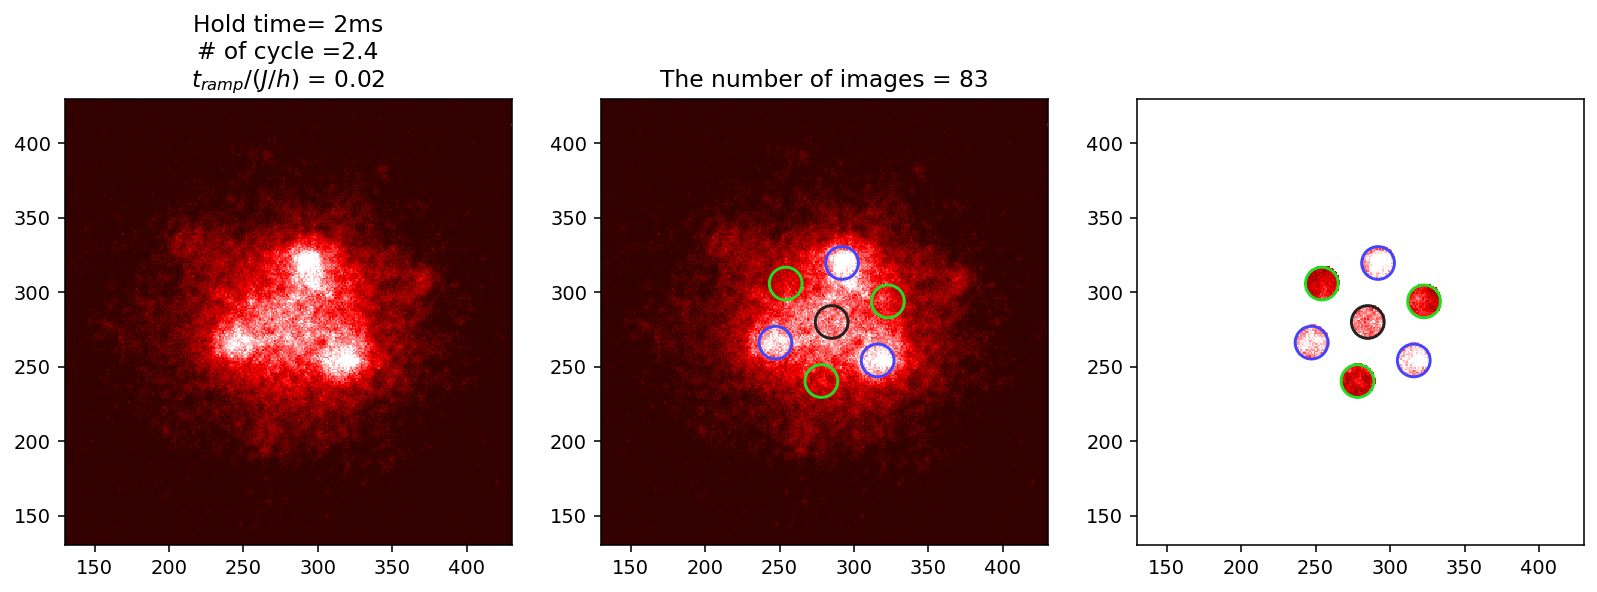

In [63]:
vmin = 50
vmax = 700
fig =plt.figure(figsize=[14,5],dpi = 140)
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title('Hold time'+ "= %d"%(unique_param[unique_param_index]*1e-3)+'ms'+'\n'+'# of cycle =%.01f'%(NoOfCycle[unique_param_index])+'\n'+r'$t_{ramp}/(J/h)$ = %.02f'%(t_over_tunneling[unique_param_index]))

ax2 = fig.add_subplot(1,3,2)
mappable =ax2.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("The number of images = %d"%(len(unique_trans_files)))

ax3 = fig.add_subplot(1,3,3)
for j in range(len(subROI_cx_list)):
    ax3.pcolormesh(extractCircleROI(np.average(unique_trans_files,axis=0), subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)

for i in range(len(subROI_cx_list)):
    if i == 0:
        color = '#222222'
    elif i<len(momentum_peaks_C1_dx_list)+1:
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax2, color=color, lw=1.5)
    region.plot(ax=ax3, color=color, lw=1.5)

In [38]:
def calculateVisibility(trans_files, subROI_cx_list, subROI_cy_list, r):
    center_list = []
    side1_list = []
    side2_list = []
    visibility_list = []
    for j in range(len(trans_files)):
        center_list.append(OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[0], subROI_cy_list[0],r))
        side1_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(1,len(momentum_peaks_C1_dx_list)+1,1)))))
        side2_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(len(momentum_peaks_C1_dx_list)+1,len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list)+1,1)))))
        visibility_list.append((side1_list[-1]-side2_list[-1])/(side1_list[-1]+side2_list[-1]))
    x_list = np.arange(0,len(unique_trans_files),1)
    return x_list, visibility_list, center_list

x_list, visibility_list, center_list = calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r)

Text(0.5, 0, 'Number of occurence')

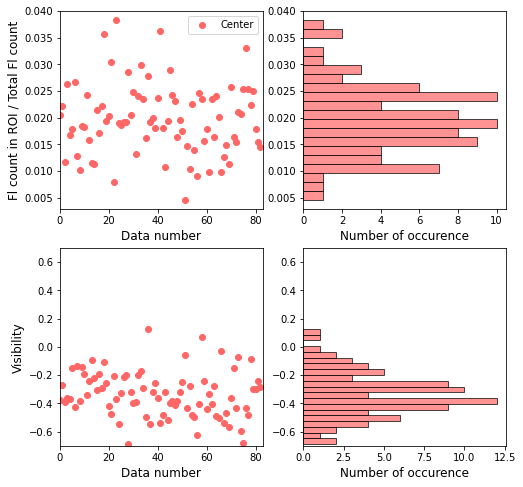

In [39]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(x_list,center_list,  marker='o', c='#ff6666',label='Center')
ax1.set_xlabel(r'Data number',fontsize=12)
ax1.set_ylabel('Fl count in ROI / Total Fl count',fontsize=12)
ax1.set_xlim(0,len(unique_trans_files))
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(np.array(center_list),bins=20,color='#ff6666', edgecolor='black', alpha=0.7,orientation='horizontal')
ax2.set_xlabel('Number of occurence',fontsize=12)

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibility_list,  marker='o', c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility',fontsize=12)
ax3.set_xlim(0,len(unique_trans_files))
ax3.set_ylim(-0.7,0.7)

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibility_list),bins=20,color='#ff6666', edgecolor='black', alpha=0.7,orientation='horizontal')
ax4.set_ylim(-0.7,0.7)
ax4.set_xlabel('Number of occurence',fontsize=12)

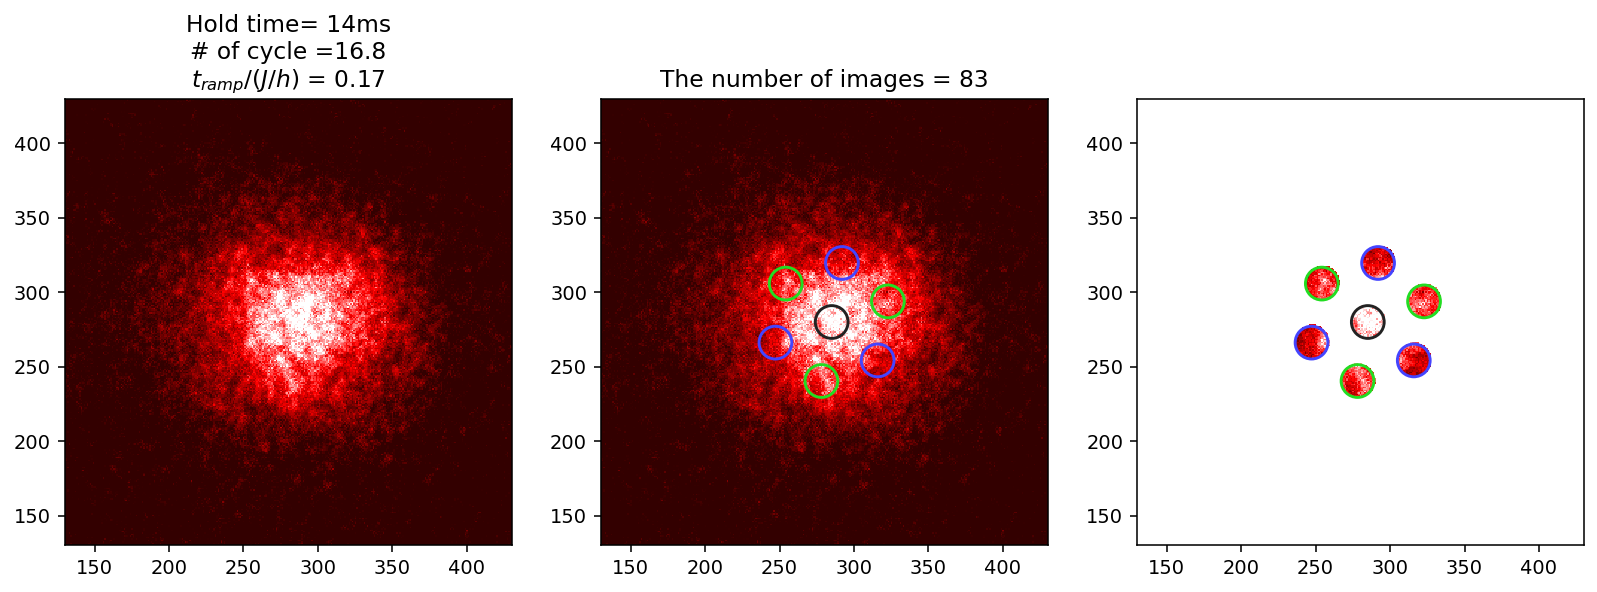

In [67]:
unique_param_index = 7
unique_trans_files = createUniqueTransFiles(img_trans_list, scan_param, unique_param, unique_param_index)
vmin = 50
vmax = 500
fig =plt.figure(figsize=[14,5],dpi = 140)
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title('Hold time'+ "= %d"%(unique_param[unique_param_index]*1e-3)+'ms'+'\n'+'# of cycle =%.01f'%(NoOfCycle[unique_param_index])+'\n'+r'$t_{ramp}/(J/h)$ = %.02f'%(t_over_tunneling[unique_param_index]))

ax2 = fig.add_subplot(1,3,2)
mappable =ax2.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("The number of images = %d"%(len(unique_trans_files)))

ax3 = fig.add_subplot(1,3,3)
for j in range(len(subROI_cx_list)):
    ax3.pcolormesh(extractCircleROI(np.average(unique_trans_files,axis=0), subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)

for i in range(len(subROI_cx_list)):
    if i == 0:
        color = '#222222'
    elif i<len(momentum_peaks_C1_dx_list)+1:
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax2, color=color, lw=1.5)
    region.plot(ax=ax3, color=color, lw=1.5)

Text(0.5, 0, 'Number of occurence')

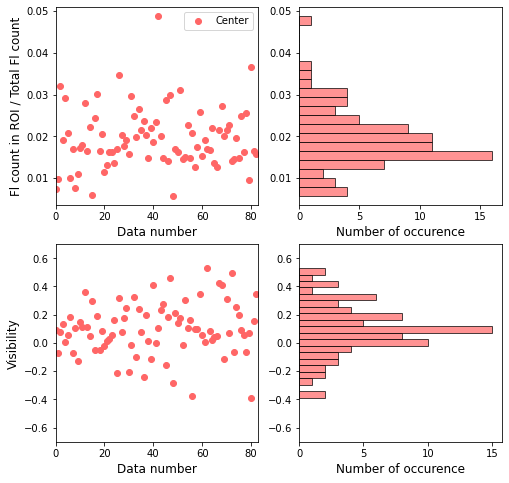

In [68]:
x_list, visibility_list, center_list = calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r)
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(x_list,center_list,  marker='o', c='#ff6666',label='Center')
ax1.set_xlabel(r'Data number',fontsize=12)
ax1.set_ylabel('Fl count in ROI / Total Fl count',fontsize=12)
ax1.set_xlim(0,len(unique_trans_files))
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(np.array(center_list),bins=20,color='#ff6666', edgecolor='black', alpha=0.7,orientation='horizontal')
ax2.set_xlabel('Number of occurence',fontsize=12)

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibility_list,  marker='o', c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility',fontsize=12)
ax3.set_xlim(0,len(unique_trans_files))
ax3.set_ylim(-0.7,0.7)

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibility_list),bins=20,color='#ff6666', edgecolor='black', alpha=0.7,orientation='horizontal')
ax4.set_ylim(-0.7,0.7)
ax4.set_xlabel('Number of occurence',fontsize=12)

In [43]:
visibility_by_unique_param = []
center_by_unique_param = []
sd_visibility_by_unique_param = []
sd_center_by_unique_param = []

subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)

for i in range(len(unique_param)):
    unique_param_index = i
    unique_trans_files = createUniqueTransFiles(img_trans_list, scan_param, unique_param, unique_param_index)
    x_list, visibility_list, center_list = calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r)
    visibility_by_unique_param.append(np.average(visibility_list))
    center_by_unique_param.append(np.average(center_list))
    sd_visibility_by_unique_param.append(np.std(visibility_list))
    sd_center_by_unique_param.append(np.std(center_list))

In [44]:
fl_count_by_unique_param = []
sd_fl_count_by_unique_param = []
for i in range(len(unique_param)):
    fl_count_tmp = []
    for j in range(len(trans_files)):
        if unique_param[i] == scan_param[j]:
            fl_count_tmp.append(flcount[j])
    fl_count_by_unique_param.append(np.average(fl_count_tmp))
    sd_fl_count_by_unique_param.append(np.std(fl_count_tmp))

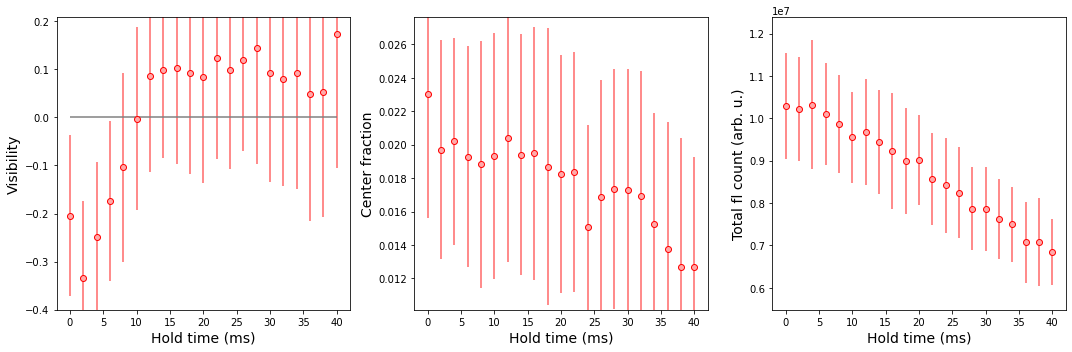

In [51]:
fontsize = 14
fig =plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,3,1)
ax1.errorbar(unique_param*1e-3, visibility_by_unique_param, sd_visibility_by_unique_param,fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa', label = "Data")
ax1.set_xlabel('Hold time (ms)', fontsize=fontsize)
ax1.set_ylabel('Visibility', fontsize=fontsize)
ax1.set_ylim(1.2*np.min(visibility_by_unique_param),1.2*np.max(visibility_by_unique_param))
ax1.hlines(y=0,xmin=np.min(unique_param*1e-3), xmax=np.max(unique_param*1e-3),color='gray')

ax2 = fig.add_subplot(1,3,2)
ax2.errorbar(unique_param*1e-3, center_by_unique_param, sd_center_by_unique_param, fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa', label = "Data")
ax2.set_xlabel('Hold time (ms)', fontsize=fontsize)
ax2.set_ylabel('Center fraction', fontsize=fontsize)
ax2.set_ylim(0.8*np.min(center_by_unique_param),1.2*np.max(center_by_unique_param))

ax3 = fig.add_subplot(1,3,3)
ax3.errorbar(unique_param*1e-3, fl_count_by_unique_param, sd_fl_count_by_unique_param, fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa', label = "Data")
ax3.set_xlabel('Hold time (ms)', fontsize=fontsize)
ax3.set_ylabel('Total fl count (arb. u.)', fontsize=fontsize)
ax3.set_ylim(0.8*np.min(fl_count_by_unique_param),1.2*np.max(fl_count_by_unique_param))
plt.tight_layout()
